# MNIST Odd-Even classification with TensorFlow (SVM)

## Data loading

Let's load the dataset using the Keras API implementation included in TensorFlow.

As we only want to classify the images between **odd** and **even** numbers, we will map labels to *1* if odd or *0* if even.

In [1]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Keep original test numbers for displaying misslcasificationsx
y_numbers = y_test

# Set Even or Odd labels for each sample
y_train = np.array(list(map(lambda x: x%2, y_train)), dtype=np.float32)
y_test = np.array(list(map(lambda x: x%2, y_test)), dtype=np.float32)

# Reshape to TF API (#img, rows, cols, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

## SVM Model

In [2]:
class SVMClassifier:
    def __init__(self, train_data=None):
        data, labels = train_data
        labels = self._transform_labels(labels)
        data = self._flatten_input(data)
        self.train_data = (data, labels)

        self.assemble_graph()

        self._open_session()
        
        self._draw_graph_tensorboard()

        if train_data:
            self.train()     

   
    def assemble_graph(self, learning_rate = 0.02):
        self.X = tf.placeholder(name='X', dtype=tf.float32, shape=(None, 28*28))
        self.Y = tf.placeholder(name='Y', dtype=tf.float32, shape=(None, 1))
        
        W = tf.Variable(tf.random_normal(shape=(28*28, 1)))
        b = tf.Variable(tf.random_normal(shape=(1, 1)))
        
        # Output = X*W - b
        output = tf.subtract(tf.matmul(self.X, W), b)
        self.predicted_class = tf.sign(output)

        # Loss = mean(max(0, 1 - pred*actual)) + alpha * ||W||^2
        alpha = tf.constant(0.001, dtype=tf.float32)
        l2_norm = tf.reduce_sum(tf.square(W))
        
        hinge_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(output, self.Y))))
        margin_term = tf.multiply(alpha, l2_norm)
        
        self.loss = tf.add(hinge_term, margin_term)
        
        # Optimizer
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        # Accuracy
        correct_pred = tf.equal(self.predicted_class, self.Y)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

 
    def train(self, epochs=20, minibatch_size=256):
        for epoch in range(1, epochs + 1):
            epoch_loss = 0.0            
            epoch_accuracy = 0.0
            
            for batch_idx, (features, labels) in enumerate(self._create_minibatches(minibatch_size)):
                d = { self.X: features, self.Y: labels }
                loss, _, acc = self.sess.run([self.loss, self.optimizer, self.accuracy], feed_dict=d)
                
                epoch_loss += loss
                epoch_accuracy += acc
                
            epoch_loss /= batch_idx
            epoch_accuracy /= batch_idx
                
            msg = 'Epoch: {:>2}\tLoss: {:2.6f}\tAccuracy: {:5.2f}%'
            print(msg.format(epoch, epoch_loss, epoch_accuracy * 100))
            

    def predict(self, data):
        d = { self.X: self._flatten_input(data) }
        return self.sess.run(self.predicted_class, feed_dict=d)

        
    def _create_minibatches(self, minibatch_size):
        pos = 0

        data, labels = self.train_data
        n_samples = len(labels)

        batches = []
        while pos + minibatch_size < n_samples:
            batches.append((data[pos:pos+minibatch_size,:], labels[pos:pos+minibatch_size]))
            pos += minibatch_size

        if pos < n_samples:
            batches.append((data[pos:n_samples,:], labels[pos:n_samples]))

        return batches
    
    
    def _transform_labels(self, labels):
        transformed_labels = list(map(lambda x: 1 if x else -1, labels))
        transformed_labels = np.array(transformed_labels, dtype=np.float32)
        return transformed_labels.reshape(-1, 1)
        

    def _flatten_input(self, data):
        return data.reshape(-1, 28*28)

    
    def _open_session(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    
    def _draw_graph_tensorboard(self):
        writer = tf.summary.FileWriter('./tmp_svm', self.sess.graph)
        writer.close()

In [3]:
from sklearn.metrics import accuracy_score, f1_score

svm = SVMClassifier((x_train, y_train))
predictions = svm.predict(x_test)

# Cast to {0, 1} to check accuracy
predictions = list(map(lambda x: 1 if x >= 0 else 0, predictions))
predictions = np.array(predictions, dtype=np.float32)

print('\nTesting score accuracy: {}'.format(accuracy_score(y_test, predictions)))
print('\nTesting score F1: {}'.format(f1_score(y_test, predictions)))

Epoch:  1	Loss: 865.034776	Accuracy: 80.40%
Epoch:  2	Loss: 614.292148	Accuracy: 83.14%
Epoch:  3	Loss: 588.362606	Accuracy: 84.05%
Epoch:  4	Loss: 582.742527	Accuracy: 84.10%
Epoch:  5	Loss: 568.427772	Accuracy: 84.26%
Epoch:  6	Loss: 564.773950	Accuracy: 84.44%
Epoch:  7	Loss: 552.023931	Accuracy: 84.57%
Epoch:  8	Loss: 505.714534	Accuracy: 85.45%
Epoch:  9	Loss: 540.923738	Accuracy: 84.61%
Epoch: 10	Loss: 528.514424	Accuracy: 85.06%
Epoch: 11	Loss: 532.269175	Accuracy: 84.84%
Epoch: 12	Loss: 524.613143	Accuracy: 85.02%
Epoch: 13	Loss: 535.555661	Accuracy: 84.86%
Epoch: 14	Loss: 528.481609	Accuracy: 84.92%
Epoch: 15	Loss: 527.881130	Accuracy: 84.87%
Epoch: 16	Loss: 517.326259	Accuracy: 85.14%
Epoch: 17	Loss: 535.698321	Accuracy: 84.96%
Epoch: 18	Loss: 536.880344	Accuracy: 84.93%
Epoch: 19	Loss: 507.879667	Accuracy: 85.24%
Epoch: 20	Loss: 527.566784	Accuracy: 85.25%

Testing score accuracy: 0.8892

Testing score F1: 0.8915426781519186


## Missclassifications

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

def plot_missclasifications(preds):
    count = 0
    plt.figure(figsize=(20, 10))
    for i, pred in enumerate(preds):
        if pred != y_test[i]:
            msg = '{} ({})'
            msg = msg.format('Odd' if preds[i] else 'Even', str(y_numbers[i]))
        
            plt.subplot(3, 10, count + 1)
            plt.title(msg)
            plt.axis('off')
            plt.imshow(x_test[i].reshape(28, 28), cmap=cm.binary)
            count += 1
            if count == 30:
                break

Some missclassification examples:

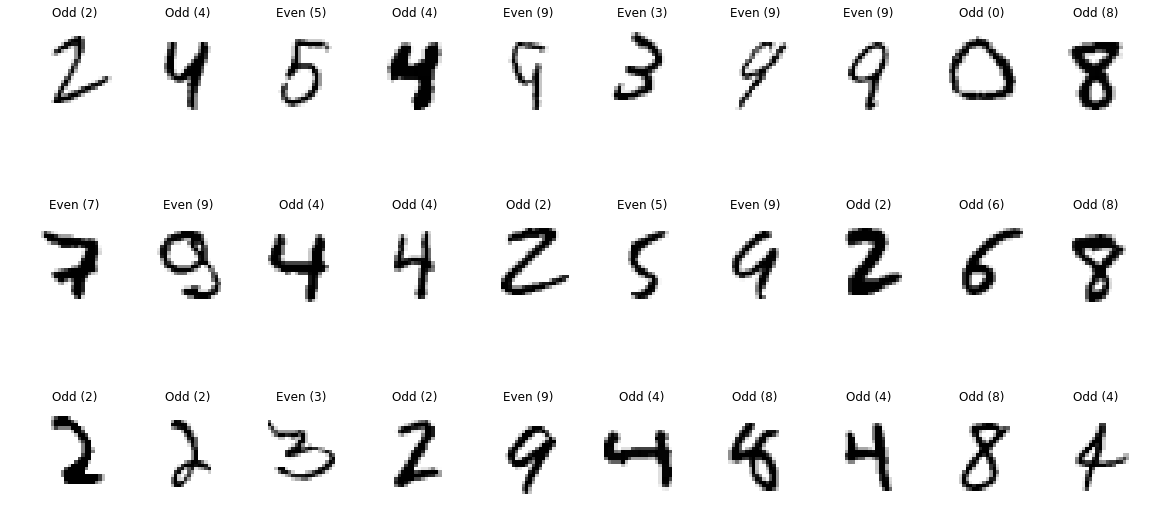

In [5]:
plot_missclasifications(predictions)

## TF Graph Visualization

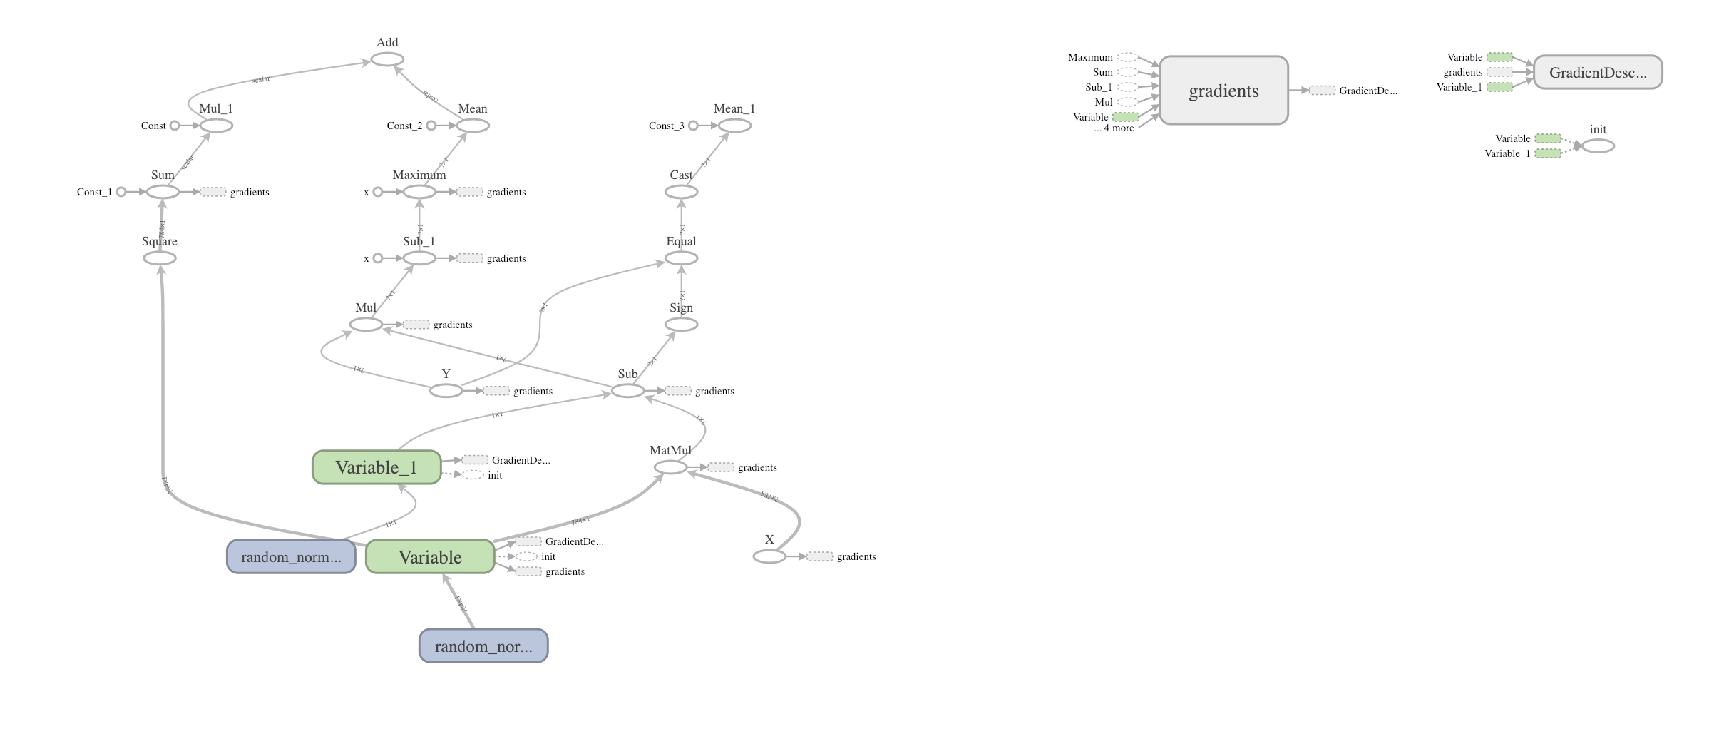

In [7]:
import matplotlib.image as mpimg

plt.figure(figsize=(30, 20))

img = mpimg.imread('tf_graph_svm.png')
imgplot = plt.imshow(img)

plt.axis('off')
plt.show()